Deze slides zijn gebaseerd op

- Hoofdstuk 12 van *Introduction to Statistical Learning* van James, Witten, Hastie en Tibshirani
- Hoofdstuk 17 van *Deep learning with Python* van Chollet

---

#### Planning

9. Bayesiaanse kansrekening en statistiek
10. Graphical networks
11. (Restricted) Boltzman machines en Belief networks
12. **PCA en auto-encoders**

<hr>

Kerstvakantie

<hr>

13. Variational auto-encoders (datapunt)
14. Generative adversarial models
15. Stable Diffusion

(Onder voorbehoud)

---

#### Inhoud

- Principal Component Analyse (PCA)
  * voor data visualisatie
  * als dimensiereductie
  * als neuraal netwerk
- Auto Encoders
  * wiskundige formulering
  * als generatief model

In [1]:
#| include: false
import os

os.environ["KERAS_BACKEND"] = "torch"

import keras
import torch

if torch.cuda.is_available():
    print('Notebook gebruikt windows GPU')
elif torch.mps.is_available():
    print('Notebook gebruikt apple GPU')
else:
    print('Notebook gebruikt CPU')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from ipywidgets import interactive


Notebook gebruikt apple GPU


In [2]:
X = np.random.multivariate_normal([0,0],[[1,0.9],[0.9,1]], size = 100)

---

#### Principal component analyse

Een principal component analyse (PCA) is een statistische techniek die voor een aantal doeleinden gebruikt kan worden:

- Data verkenning
- Data visualisatie
- Correlaties verwijderen
- Dimensiereductie


---

#### Principal component analyse

Een PCA probeert een rotatie te vinden zodat de geroteerde data geen correlaties bevat. Bijvoorbeeld, na een rotatie onder een hoek van $45^\circ$ veranderd de gecorreleerde data links in ongecorreleerde data rechts.

$$
\begin{pmatrix} 
P_1 \\ P_2 
\end{pmatrix} = 
\begin{bmatrix} 
\cos(\pi/4) & -\sin(\pi/4) \\ 
\sin(\pi/4) & \cos(\pi/4)
\end{bmatrix}
\begin{pmatrix} 
X_1 \\ X_2 
\end{pmatrix}
$$

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/var/folders/5k/b0z5f4vd1rqdvfbqcmvs4t1r0000gn/T/ipykernel_36913/973138125.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.annotate('$45^\circ$', (1.5, 0.4))


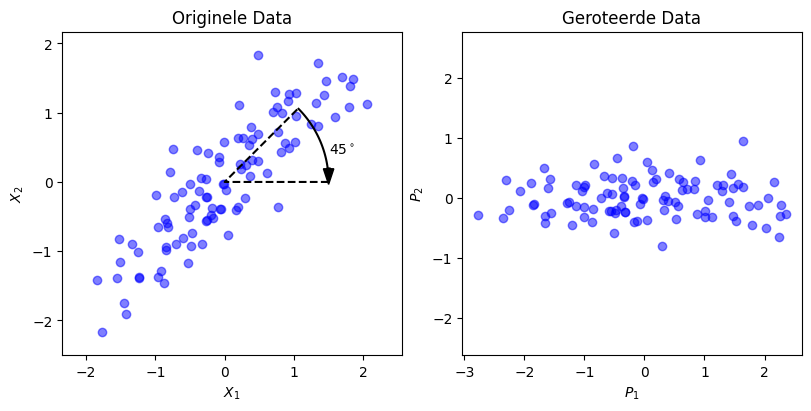

In [3]:
t = np.pi/4
R = np.array([[np.cos(t), -np.sin(t)],[np.sin(t), np.cos(t)]])
P = X.dot(R)

plt.figure(figsize = (8,4), layout = 'constrained')
plt.subplot(1,2,1)
plt.plot(X[:,0], X[:,1], 'bo', alpha = 0.5)
plt.plot(1.5*np.cos(np.arange(0, t, 0.01)), 1.5*np.sin(np.arange(0, t, 0.01)), 'k-')
plt.plot([1.5,0,1.5*np.cos(t)], [0, 0, 1.5*np.sin(t)], 'k--')
plt.arrow(1.5, 0.2, 0, -0.01, width=0.05, fc='k')
plt.annotate('$45^\circ$', (1.5, 0.4))
plt.axis('equal')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Originele Data')
plt.subplot(1,2,2)
plt.plot(P[:,0], P[:,1], 'bo', alpha = 0.5)
plt.axis('equal')
plt.xlabel('$P_1$')
plt.ylabel('$P_2$')
plt.title('Geroteerde Data')
plt.show()

---

#### Principal component analyse

Dimensiereductie kunnen we nu krijgen door een van de geroteerde variabelen (de zgn. tweede *principal component* `plat te slaan') en daarna terug te roteren.

$$
\begin{pmatrix} 
X^{new}_1 \\ X^{new}_2 
\end{pmatrix} = 
\begin{bmatrix} 
\cos(\pi/4) & -\sin(\pi/4) \\ 
\sin(\pi/4) & \cos(\pi/4)
\end{bmatrix}^T
\begin{pmatrix} 
P_1 \\ 0 
\end{pmatrix}
$$

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/5k/b0z5f4vd1rqdvfbqcmvs4t1r0000gn/T/ipykernel_36913/3386928194.py:12: SyntaxWarning: invalid escape sequence '\c'
  plt.annotate('$45^\circ$', (1.35, 0.7))


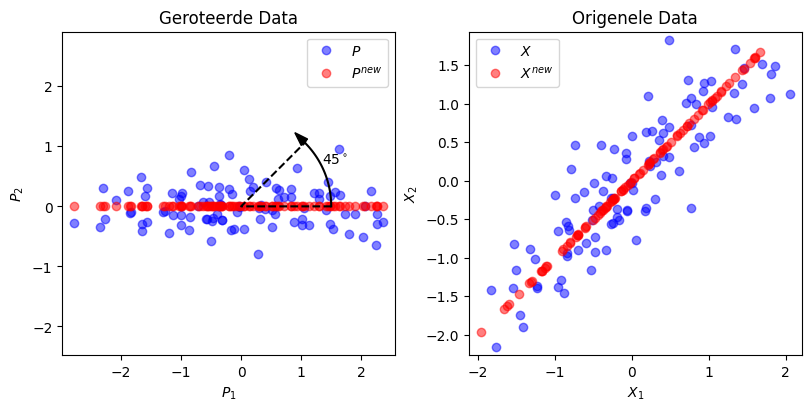

In [4]:
Pnew = P.copy()
Pnew[:,1] = 0
Xnew = Pnew.dot(R.T)

plt.figure(figsize = (8,4), layout = 'constrained')
plt.subplot(1,2,1)
plt.plot(P[:,0], P[:,1], 'bo', alpha = 0.5, label = '$P$')
plt.plot(Pnew[:,0], Pnew[:,1], 'ro', alpha = 0.5, label = '$P^{new}$')
plt.plot(1.5*np.cos(np.arange(0, t, 0.01)), 1.5*np.sin(np.arange(0, t, 0.01)), 'k-')
plt.plot([1.5,0,1.5*np.cos(t)], [0, 0, 1.5*np.sin(t)], 'k--')
plt.arrow(1.5*np.cos(t), 1.5*np.sin(t), -0.01*np.sin(t), 0.01*np.cos(t), width=0.05, fc='k')
plt.annotate('$45^\circ$', (1.35, 0.7))
plt.axis('equal')
plt.xlabel('$P_1$')
plt.ylabel('$P_2$')
plt.legend()
plt.title('Geroteerde Data')
plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], 'bo', alpha = 0.5, label = '$X$')
plt.plot(Xnew[:,0], Xnew[:,1], 'ro', alpha = 0.5, label = '$X^{new}$')
plt.axis('equal')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.title('Origenele Data')
plt.show()

---

#### Principal component analyse

Een principal component analyse (PCA) probeert deze rotatiematrix te bepalen, dit kan op een aantal manieren:

- Kijken naar de spreiding
  * Vind de richting met de grootste spreiding
  * Vind de richting hier loodrecht op met de grootste spreiding
  * etc...
- Kijken naar de correlaties
  * Diagonaliseer de correlatiematrix
- Kijken naar de getransformeerde $X^{new}$
  * Minimaliseer de reconstructiefout
  
Wiskundig gezien zijn deze manieren allemaal equivalent.

In [5]:
pca = PCA(n_components=1).fit(X)
P = pca.transform(X)
Xnew = pca.inverse_transform(P)

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000,-1)).astype("float32") / 255
x_test = x_test.reshape((10000,-1)).astype("float32") / 255

pca = PCA(n_components=2).fit(x_train)
p = pca.transform(x_train)


---

#### PCA voor data visualisatie

PCA is een unsupervised techniek, hieronder hebben we een PCA gefit op de MNIST data, de labels zijn niet meegenomen in de PCA, toch als we deze labels achteraf inkleuren zien we dat op de eerste twee PC's deze klasses al redelijk gescheiden worden.

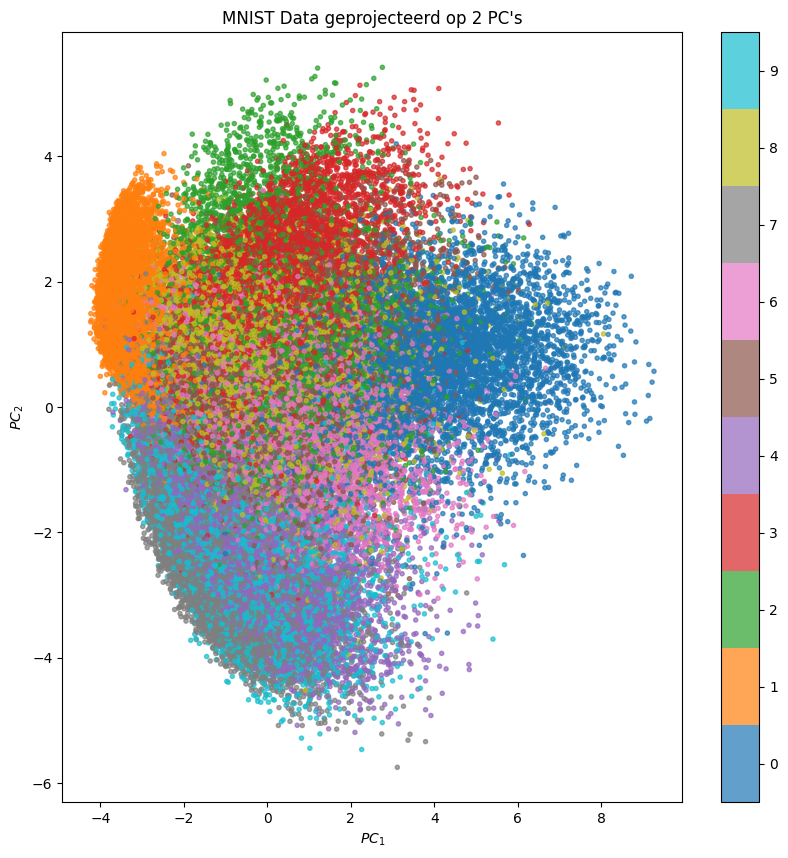

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(p[:,0], p[:,1], c = y_train, marker='.', alpha = 0.7, cmap='tab10', vmin=-0.5, vmax=9.5)
plt.colorbar(ticks = range(10))
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')
plt.title("MNIST Data geprojecteerd op 2 PC's")
plt.show()

---

#### PCA als dimensiereductie

Een PCA van $p$ variabelen naar $q$ componenten is te formuleren als een optimalisatieprobleem. Als ${\bf X}$ een $n \times p$ data matrix is, vind een $p \times q$ matrix ${\bf R}$ zodat

$$
\begin{aligned}
{\bf P} &= {\bf X R}, \\
{\bf X}_{new} &= {\bf R}^T {\bf P}
\end{aligned}
$$

en

$$
\text{Reconstruction Error}^2 = \frac{1}{n} \sum_{i=1}^n |\vec{x}_i - \vec{x}_{new,i}|^2
$$

minimaal is.

In [8]:
pca5 = PCA(n_components=5).fit(x_train)
p5 = pca5.transform(x_train)
samples = np.zeros((8,5))
for i in range(8):
    for j in range(5):
        samples[i,j] = np.random.choice(p5[:,j])
genimg = pca5.inverse_transform(samples)

---

#### PCA als generatief model

Een PCA word traditioneel niet echt gezien als een generatief model, maar omdat de *principal components* in de latent space onderling (lineair) onafhankelijk zijn kunnen we wel makkelijk trekkingen doen. 

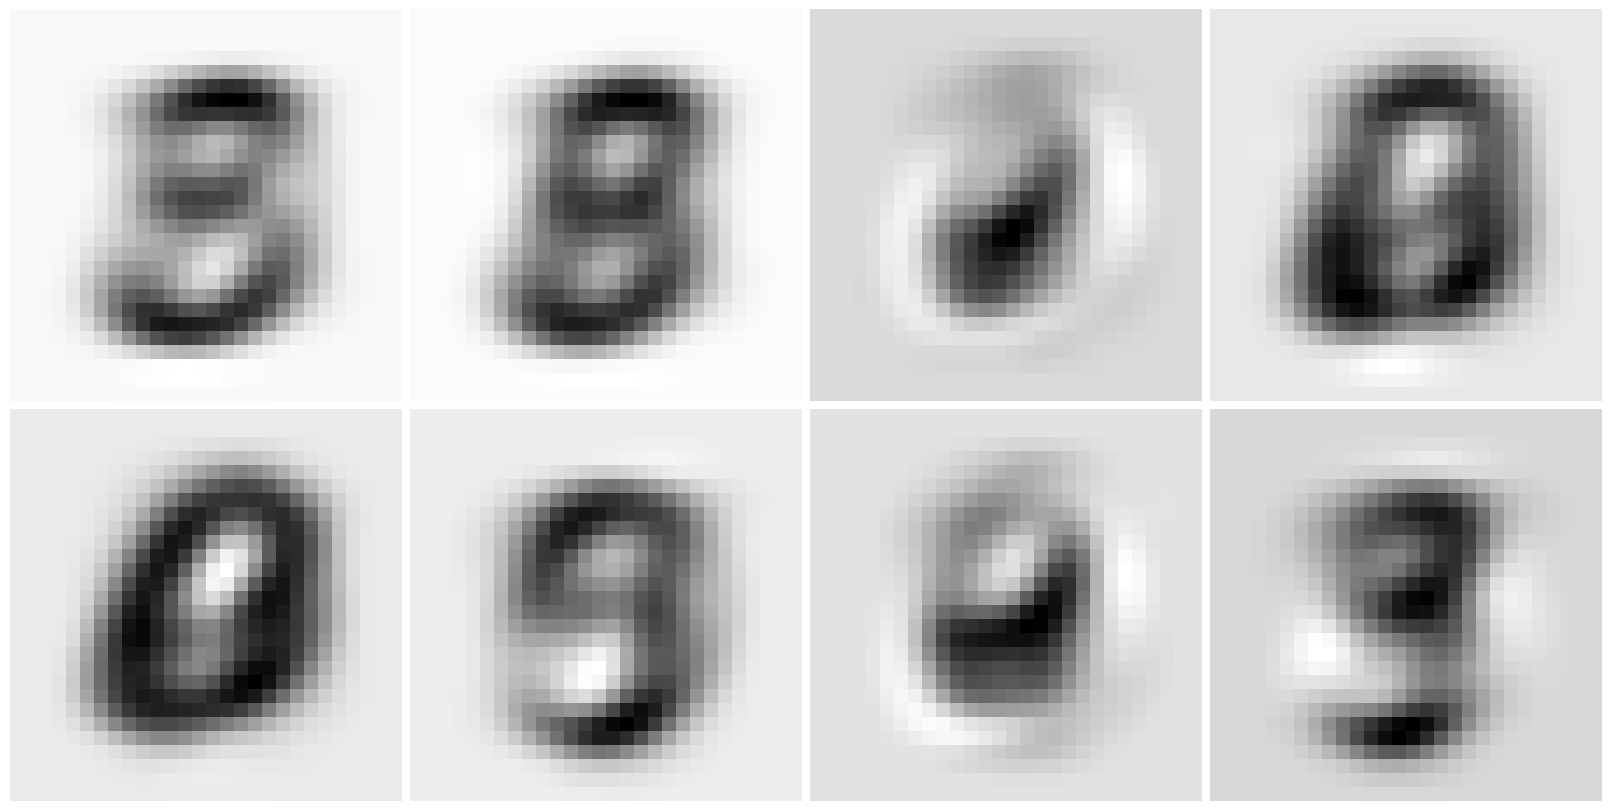

In [9]:
plt.figure(figsize=(16,8), layout='constrained')
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(1-genimg[i,:].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

In [10]:
def interpolateplot(t):
    x = pca5.inverse_transform((1-t)*p5[1] + t*p5[9])
    plt.figure(figsize=(5,5))
    plt.imshow(1-x.reshape(28,28), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    

---

#### PCA als generatief model

Of we kunnen tussen twee punten in de latent space interpoleren. Zo genereren we kunstmatige afbeeldingen die op beide plaatjes lijken.

$$
\vec{p}(t) = (1-t) \vec{p}_0 + t \vec{p}_4, \qquad \text{voor $t \in [0,1]$}.
$$

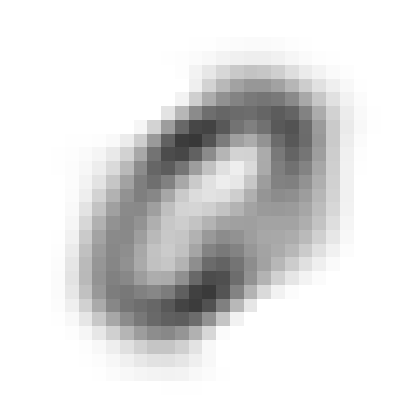

In [11]:
interpolateplot(0.5)

In [12]:

interactive(interpolateplot, t=(0.0,1.0))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

---

#### PCA als neuraal netwerk

Vind een $p \times q$ matrix $\bf{R}$ zodat ${\bf X}_{new} = {\bf R}^T {\bf X}\bf{R}$ zodat de reconstructiefout minimaal is.

Omdat 

- lagen (zonder activatie) in een neuraal netwerk matrix vermenigvuldigingen uitvoeren,
- de *reconstruction error* in feite een MSE is,

komt dit neer op het trainen van een neuraal netwerk met 

- een *input* laag van grootte $p$, 
- een *hidden* laag van grootte $q$, met gewichten ${\bf R}$
- een uitvoer laag van grootte $p$, met gewichten ${\bf R}^T$ 

Dit netwerk probeert $\vec{x}$ aan de hand van $\vec{x}$ te voorspellen door het door een lager dimensionale laag te voeren.

---

#### PCA als neuraal netwerk

Dit netwerk kunnen we ook maken en trainen.

In [13]:
inputs = keras.Input(shape=(X.shape[1],))
x = keras.layers.Dense(1)(inputs)
outputs = keras.layers.Dense(2)(x)
pcamodel = keras.Model(inputs,outputs)
pcamodel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

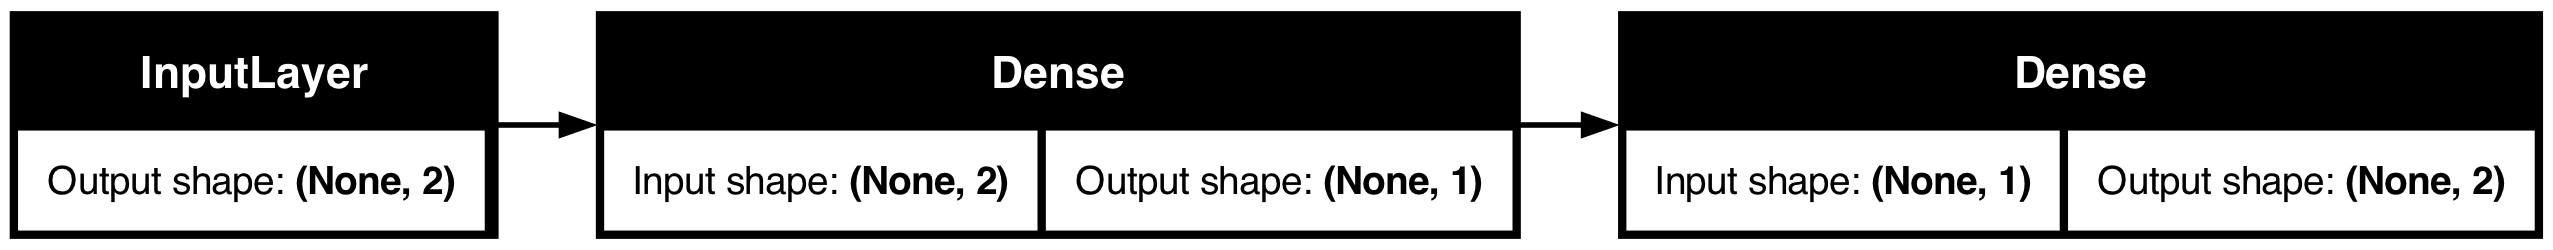

In [45]:
keras.utils.plot_model(pcamodel, show_shapes=True, rankdir = 'LR')

In [15]:
#| include: false
pcamodel.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.05), loss="mse")

history = pcamodel.fit(X,X,epochs=15,batch_size=32)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.8579
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6674
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5307
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3834
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2724
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1793
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1044
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0655
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0548
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0610
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0648
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0616
Epoch 13/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0568
Epoch 14/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0545
Epoch 15/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0530


---

#### PCA als neuraal netwerk

Resultaten zijn vrijwel hetzelfde als een PCA.

In [16]:
Xnew = pcamodel.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


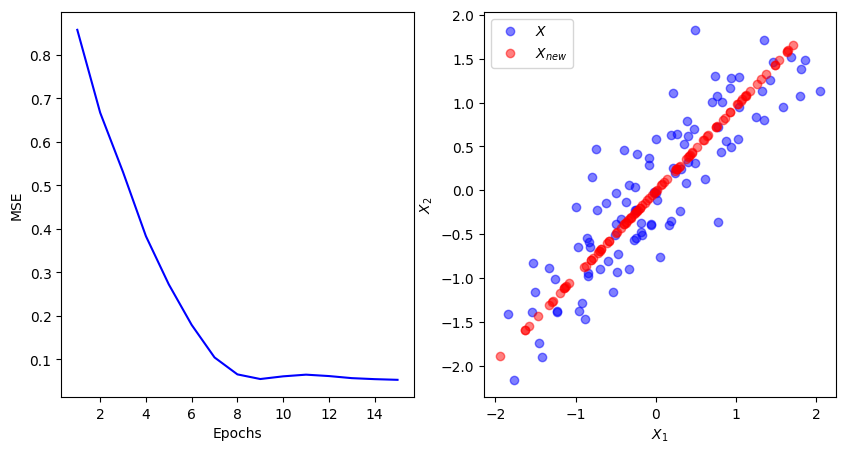

In [17]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(1,16), 'loss', 'b-', data = history.history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], 'bo', alpha = 0.5, label = '$X$')
plt.plot(Xnew[:,0], Xnew[:,1], 'ro', alpha = 0.5, label = '$X_{new}$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()

---

#### Auto encoders

Voordeel is dat we nu ook niet-lineaire structuren op zo'n manier kunnen modelleren.

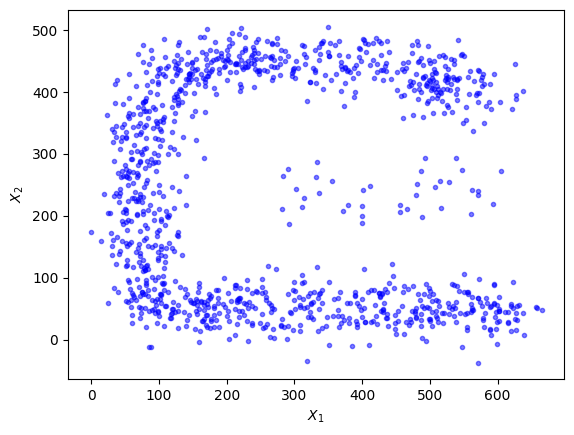

In [18]:
df = pd.read_csv('data/data_gate.csv').assign(z = lambda d: np.where(d.z == 'a',0,1))
X_train = np.array(df[['x', 'y']])

plt.scatter(x='x', y='y', color='b', marker='.',data=df, alpha = 0.5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

---

#### Autoencoders

- Encoder: $\mathbb{R}^2 \mapsto \mathbb{R}$ via twee *Dense* lagen van drie neuronen.
- Decoder: $\mathbb{R} \mapsto \mathbb{R}^2$ via twee *Dense* lagen van drie neuronen.

In [48]:


X_scale = StandardScaler().fit_transform(X_train)

inputs = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(3, activation='tanh', use_bias = True)(inputs)
x = keras.layers.Dense(3, activation='tanh',use_bias = True)(x)
x = keras.layers.Dense(1, activation='tanh',use_bias = True)(x)
x = keras.layers.Dense(3, activation='tanh',use_bias = True)(x)
x = keras.layers.Dense(3, activation='tanh',use_bias = True)(x)
outputs = keras.layers.Dense(X_scale.shape[1])(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

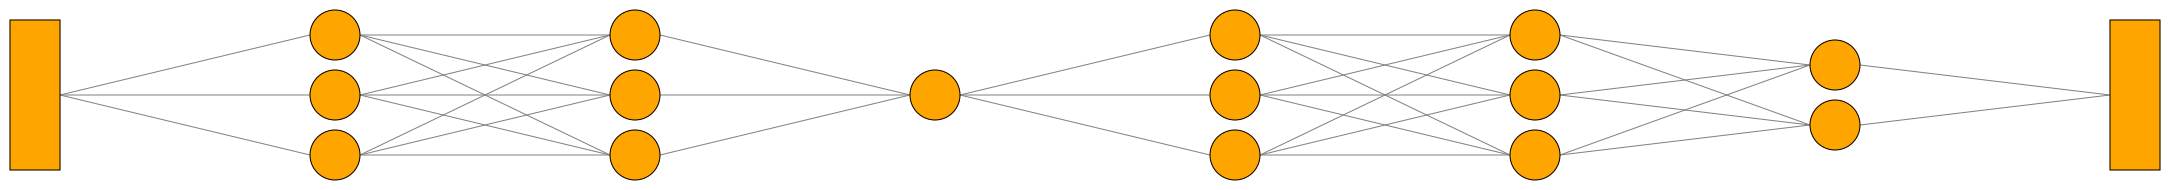

In [49]:
visualkeras.graph_view(model)

In [21]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-3), loss="mse")

In [22]:
#| include: false
history = model.fit(
    X_scale,
    X_scale,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.2283 - val_loss: 0.7613
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8138 - val_loss: 0.5986
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5586 - val_loss: 0.5897
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5086 - val_loss: 0.6126
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4997 - val_loss: 0.6184
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4951 - val_loss: 0.6145
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4923 - val_loss: 0.6068
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4913 - val_loss: 0.6000
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4900 - val_loss: 0.6045
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4897 - val_loss: 0.6013
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4885 - val_loss: 0.6110
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [23]:
#| include: false
Xnew = model.predict(X_scale)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


---

#### Autoencoders

Het model vind de vorm in de data.

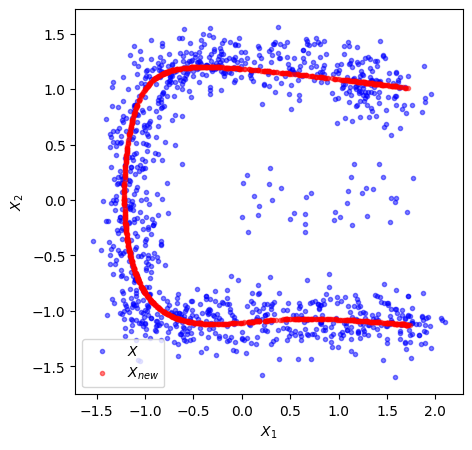

In [24]:
plt.figure(figsize = (5,5))
plt.plot(X_scale[:,0], X_scale[:,1], 'b.', alpha = 0.5, label = '$X$')
plt.plot(Xnew[:,0], Xnew[:,1], 'r.', alpha = 0.5, label = '$X_{new}$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.show()

---

#### Autoencoder - wiskundige formulering

Een autoencoder bestaat uit twee delen:

- Een encoder, die de invoer transformeert naar een midden laag
- Een decoder, die de midden laag terug transformeert naar de invoer

Wiskundig geformuleerd is de encoder een functie $\vec{h} = f(\vec{x})$ die de invoer $\vec{x} \in \mathbb{R}^p$ transformeert naar $\mathbb{R}^q$. De decoder probeert de encoder te inverteren, en is een functie $\vec{x}_{new} = g(\vec{h})$ die de middenlaag transformeert van $\mathbb{R}^q$ naar $\mathbb{R}^p$.

---

#### Autoencoder - wiskundige formulering

We noemen de compositie $\vec{x}_{new} = g(f(\vec{x}))$ de *reconstructie* functie.


- Als $q << p$ dan noemen we de autoencoder *undercomplete*. Er zal zeker weten informatie verloren gaan in de reconstructie (en dit willen we vaak juist).
- Als $q >> p$ dan noemen we de autoencoder *overcomplete*. In combinatie met regularisatie (om te zorgen dat het model daadwerkelijk blijft versimpelen) zijn deze modellen vaak  krachtiger, maar moeilijker te trainen. 

In [25]:
input_img = keras.Input(shape=x_train[0].shape)
x = keras.layers.Reshape((28,28,1))(input_img)
x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation="relu")(x)
encoded = keras.layers.Dense(3, activation='relu')(x)
# at this point the representation is 2-dimensional

x = keras.layers.Dense(7 * 7 * 64, activation="relu")(encoded)
x = keras.layers.Reshape((7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoded = keras.layers.Flatten()(x)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [26]:
#| label: autoencoder-summary
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3136)           │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,284 (536.27 KB)

 Trainable params: 137,284 (536.27 KB)

 Non-trainable params: 0 (0.00 B)

/Users/robertnolet/miniforge3/envs/keras3.11torch/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


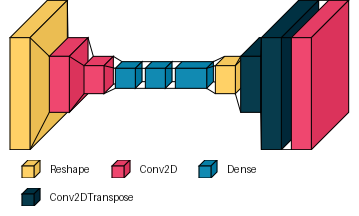

In [27]:
#| label: autoencoder-visual
visualkeras.layered_view(autoencoder, legend=True, scale_z = 0.01, type_ignore = [keras.layers.InputLayer, keras.layers.Flatten])

---

#### Voorbeeld: Auto Encoders op MNIST

We kunnen nu de MNIST data auto-encoden.

:::: {.columns}
::: {.column}

{{< contents autoencoder-summary >}}

:::
::: {.column}

{{< contents autoencoder-visual >}}

:::
::::

In [ ]:
#| include: false
hist3 = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split = 0.2)
autoencoder.save('models/MNIST_autoencoder3.keras')

In [29]:
#| include: false
autoencoder = keras.models.load_model('models/MNIST_autoencoder3.keras')

xnew = autoencoder.predict(x_train)

  28/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step 

/Users/robertnolet/miniforge3/envs/keras3.11torch/lib/python3.12/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


---

#### Voorbeeld: Autoencoders op MNIST

We kunnen nu naar de reconstructie van MNIST cijfers kijken.

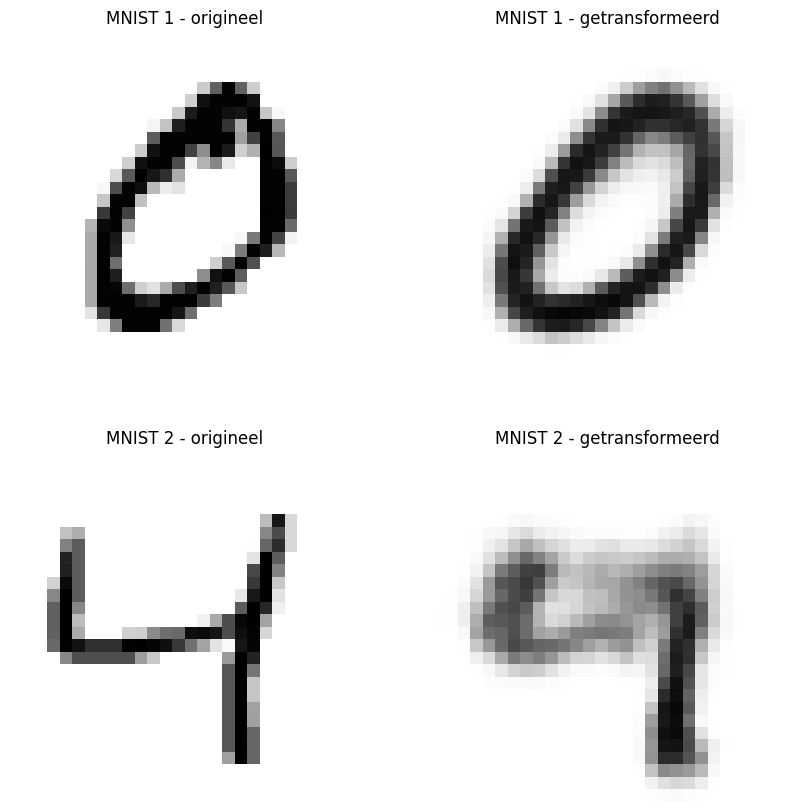

In [30]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(1-x_train[1].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 1 - origineel')
plt.subplot(2,2,2)
plt.imshow(1-xnew[1].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 1 - getransformeerd')
plt.subplot(2,2,3)
plt.imshow(1-x_train[2].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 2 - origineel')
plt.subplot(2,2,4)
plt.imshow(1-xnew[2].reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('MNIST 2 - getransformeerd')
plt.show()

In [31]:
#| include: false
encoder_model = keras.Model(autoencoder.input, autoencoder.layers[6].output)
decoder_model = keras.Model(autoencoder.layers[6].output, autoencoder.output)

latent = encoder_model.predict(x_train)
t = np.linspace(0,1,101).reshape(-1,1)
interpolated_latent = latent[1]*(1-t) + latent[2]*t

x_int = decoder_model.predict(interpolated_latent)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/robertnolet/miniforge3/envs/keras3.11torch/lib/python3.12/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


---

#### Voorbeeld: Autoencoder op MNIST

Bij de projectie op de latent space zien we dat sommige cijfers goed onderscheiden worden van de rest. 

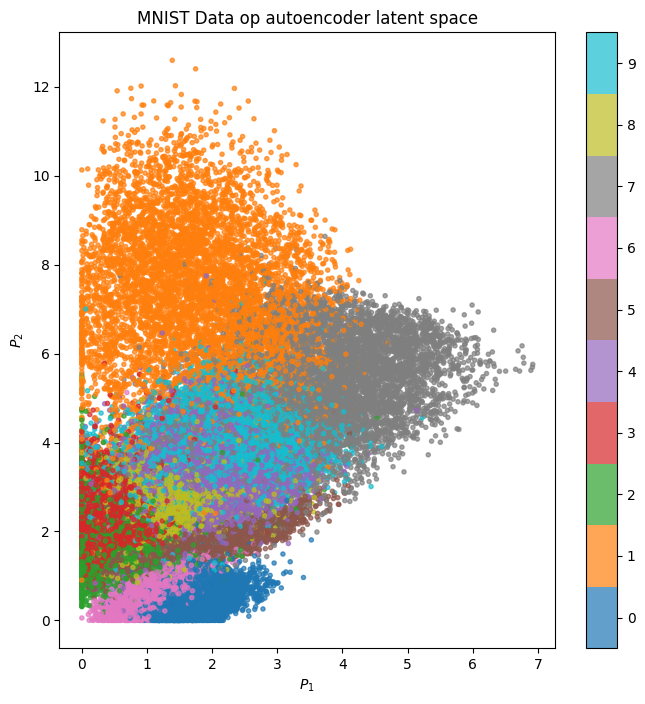

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(latent[:,0], latent[:,1], c = y_train, marker='.', alpha = 0.7, cmap='tab10', vmin=-0.5, vmax=9.5)
plt.colorbar(ticks = range(10))
plt.xlabel('$P_1$')
plt.ylabel('$P_2$')
plt.title("MNIST Data op autoencoder latent space")
plt.show()

In [33]:
def interpolateplot2(t):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(1-x_int[t].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.scatter(latent[:,0], latent[:,1], c = y_train, marker='.', alpha = 0.7, cmap='tab10', vmin=-0.5, vmax=9.5)
    plt.colorbar()
    plt.xlabel('$P_1$')
    plt.ylabel('$P_2$')
    plt.plot(interpolated_latent[t,0], interpolated_latent[t,1], 'ro')
    plt.show()

---

#### Voorbeeld: Autoencoder op MNIST

We kunnen nu tussen twee afbeeldingen interpoleren om nieuwe afbeeldingen te genereren.

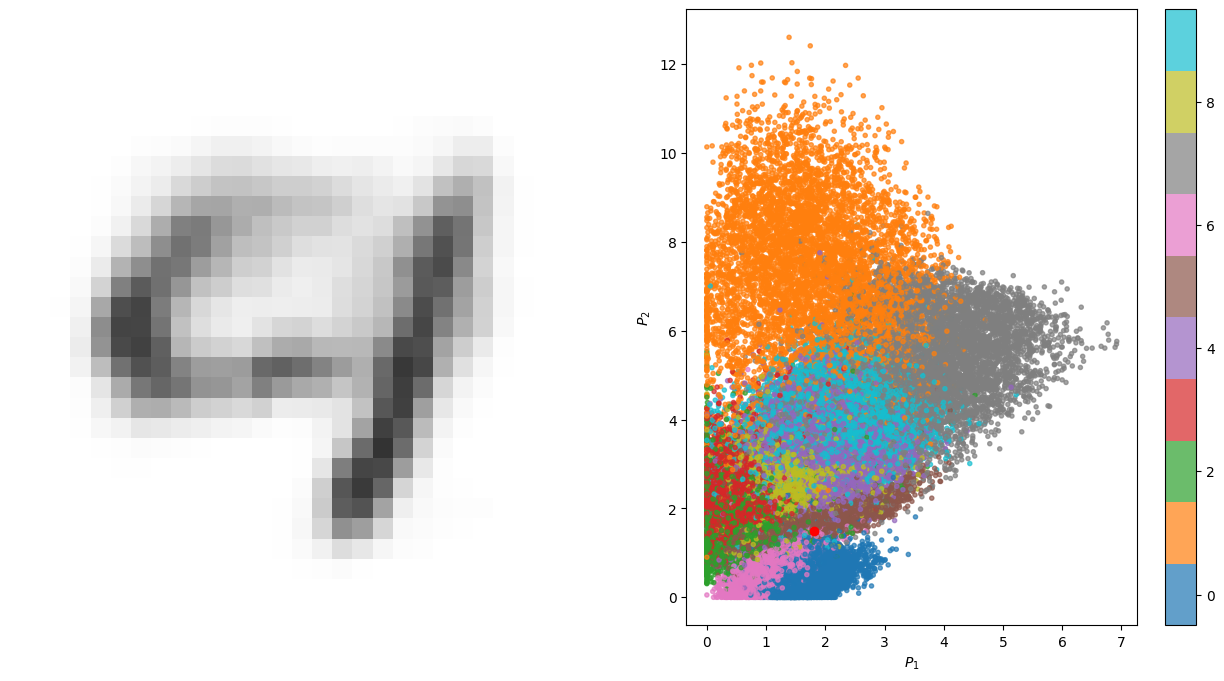

In [34]:
interpolateplot2(50)

In [35]:

interactive(interpolateplot2, t=(0, 100))

interactive(children=(IntSlider(value=50, description='t'), Output()), _dom_classes=('widget-interact',))

In [36]:
fulltree = DecisionTreeClassifier(max_depth=5).fit(latent, y_train)
alphas = fulltree.cost_complexity_pruning_path(latent, y_train)

In [37]:
#| include: false

alphas = np.unique(alphas['ccp_alphas'])

gridsearch = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid = {'ccp_alpha':alphas, 'max_depth':[8]},
    scoring='accuracy',
    verbose=1
).fit(latent, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [38]:
#| include: false

model = gridsearch.best_estimator_

print('Best alpha:', gridsearch.best_params_['ccp_alpha'])
print('Best score:', gridsearch.best_score_)

Best alpha: 8.043268147223516e-05
Best score: 0.7990666666666667


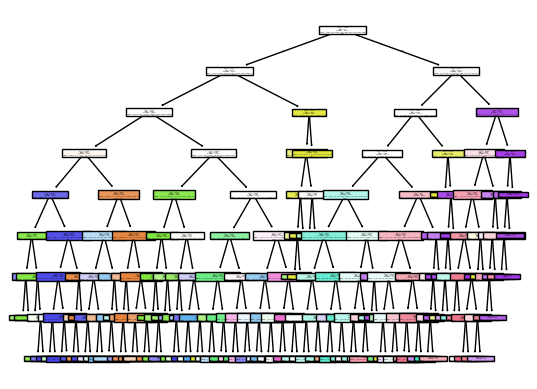

In [39]:
#| label: beslisboom

plot_tree(model, filled=True)
plt.show()

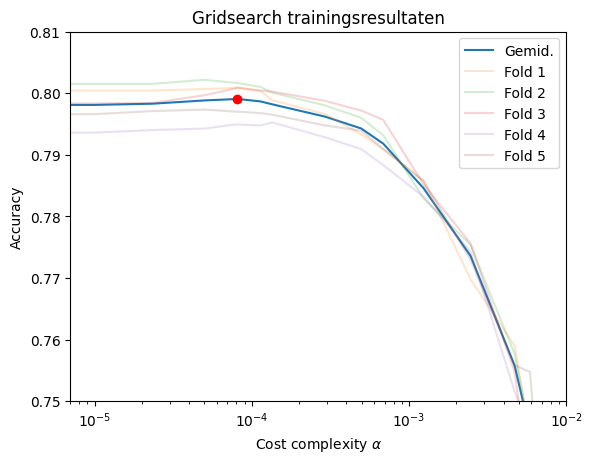

In [40]:
#| label: gridsearch

sns.lineplot(gridsearch.cv_results_, x = 'param_ccp_alpha', y = 'mean_test_score', label = 'Gemid.')
for i in range(5):
    sns.lineplot(gridsearch.cv_results_, 
                 x = 'param_ccp_alpha', 
                 y = f'split{i}_test_score', 
                 alpha = 0.2, 
                 label = f'Fold {i+1}')
plt.plot(gridsearch.best_params_['ccp_alpha'], gridsearch.best_score_, 'ro')
plt.xlabel('Cost complexity $\\alpha$')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xlim(7e-6, 1e-2)
plt.ylim(0.75, 0.81)
plt.title('Gridsearch trainingsresultaten')
plt.show()

---

#### Auto-encoder als feature extractor

We kunnen de latent space nu gebruiken als *features* om een classificatiemodel op te trainen. We fitten een beslisboom met *cost complexity pruning*.

:::: {.columns}
::: {.column}

{{< contents beslisboom >}}

:::
::: {.column}

{{< contents gridsearch >}}

:::
::::

In [41]:
#| include: false
latent_test = encoder_model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


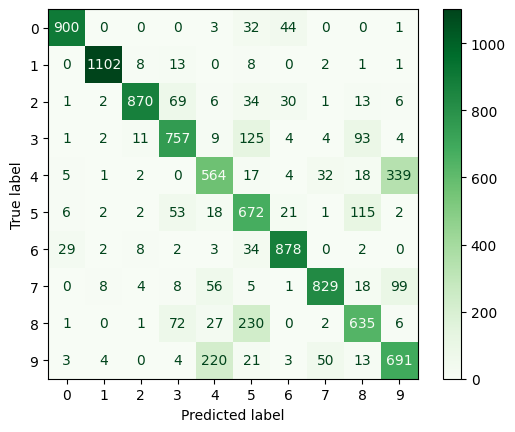

In [42]:
#| label: confusionmatrix
y_pred = model.predict(latent_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens')
plt.show()

In [43]:
#| label: classreport

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       980
           1       0.98      0.97      0.98      1135
           2       0.96      0.84      0.90      1032
           3       0.77      0.75      0.76      1010
           4       0.62      0.57      0.60       982
           5       0.57      0.75      0.65       892
           6       0.89      0.92      0.90       958
           7       0.90      0.81      0.85      1028
           8       0.70      0.65      0.67       974
           9       0.60      0.68      0.64      1009

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



---

#### Auto-encoder als feature extractor

Model haalt 80% accuracy op de test data.

:::: {.columns}
::: {.column}

{{< contents confusionmatrix >}}

:::
::: {.column}

{{< contents classreport >}}

:::
::::

---

#### Samenvatting

:::: {.columns}
::: {.column}

- PCA
  + lineair model
  + unsupervised
  + statistische techniek voor:
    - dimensiereductie
    - analyse van correlaties
    - feature extractie

:::
::: {.column}

- Autoencoder
  + niet lineair model, geïmplementeerd met neurale netwerken
  + unsupervised
  + techniek voor:
    - dimensiereductie
    - feature extractie

:::
::::

